In [2]:
!pip install qpsolvers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 4.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from io import StringIO
from qpsolvers import solve_qp
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
def rbf(first, second, gamma = 0.1):
  return  np.exp(-gamma * ((np.linalg.norm(first - second))**2))

In [5]:
def calc_parameters(alpha, y, x):
  w = np.array([0., 0.])
  for i in range(len(alpha)):
    w += alpha[i] * y[i][0] * x[i]
  min = 10000000
  max = -10000000

  for i in range(len(alpha)):
    current = rbf(w, x[i])
    if y[i][0] == 1 and min > current:
      min = current
    elif y[i][0] == -1 and max < current:
      max = current
  b = -0.5 * (min + max)
  return np.transpose(w) , b  # w is a 1 * 2 matrix

In [17]:
# Takes as input: an opened text file (raw_data),
# class to classify based on if data contains more then 2 classes (index, default = 0),
# hyperparameter c

# Outputs alphas [0, c], y (n * 1), x (n * 2)
def kernelized_svm_from_txt(raw_data, index = 0, c = 0.00552):
  raw_data.seek(0)
  lines = raw_data.readlines()
  txt = str()
  for i in range(7, len(lines)):
    txt += (lines[i] + '\n')
  txt = StringIO(txt)
  np_data = np.loadtxt(txt) # np_data now has all samples; Each sample is
                            # represented as a list of two features and a label

  x_trans = np_data[:, :2]
  y = np_data[:, 2].reshape(len(lines) - 7, 1)

  # Labeling according to chosen class
  unique_classes = np.unique(y)
  for i in range(len(y)):
    if y[i][0] == unique_classes[index]:
      y[i][0] = 1
    else:
      y[i][0] = -1

  # Signs of matrix p
  signs = np.matmul(y, np.transpose(y))

  # Matrix p
  p = np.zeros((len(y), len(y)))

  # Kernelizing p
  for i in range(len(p)):
    for j in range(len(p[0])):
      if signs[i, j] == 1:
        p[i, j] = rbf(x_trans[i], x_trans[j]) # rbf kernel
      else:
        p[i, j] = rbf(x_trans[i], x_trans[j]) # rbf kernel
        p[i, j] = -p[i, j]

  # Matrix q traspose
  q_trans = np.full((len(y), ), -1)

  # Matrices A and b
  A = np.transpose(y)
  b = np.array([0.])

  # Matrix G
  upper = np.zeros((len(y), len(y)), float)
  lower = np.zeros((len(y), len(y)), float)
  np.fill_diagonal(upper, -1)
  np.fill_diagonal(lower, 1)
  G = np.concatenate((upper, lower), axis = 0)

  # Matrix h
  h = np.concatenate((np.zeros((len(y), )), np.full((len(y), ), c)), axis = 0)

  # Solving for alpha
  alpha = solve_qp(p, q_trans, G, h, A, b, solver="osqp")

  # Offsetting
  for i in range(len(alpha)):
    if alpha[i] <= 10**(-4):
      alpha[i] = 0.
    elif alpha[i] >= (c - 10**(-3)):
      alpha[i] = c

  return x_trans, y, alpha


In [18]:
# Takes as input: 2-d features (x),
# labels (y)
# class to classify based on if data contains more then 2 classes (index, default = 0),
# hyperparameter c

# Outputs alphas [0, c], y (n * 1), x (n * 2)
def kernelized_svm(x, y, index = 0, c = 0.00552):
  x_trans = x

  # Labeling according to chosen class
  unique_classes = np.unique(y)
  for i in range(len(y)):
    if y[i][0] == unique_classes[index]:
      y[i][0] = 1
    else:
      y[i][0] = -1

  # Signs of matrix p
  signs = np.matmul(y, np.transpose(y))

  # Matrix p
  p = np.zeros((len(y), len(y)))

  # Kernelizing p
  for i in range(len(p)):
    for j in range(len(p[0])):
      if signs[i, j] == 1:
        p[i, j] = rbf(x_trans[i], x_trans[j]) # rbf kernel
      else:
        p[i, j] = rbf(x_trans[i], x_trans[j]) # rbf kernel
        p[i, j] = -p[i, j]

  # Matrix q traspose
  q_trans = np.full((len(y), ), -1)

  # Matrices A and b
  A = np.transpose(y)
  b = np.array([0.])

  # Matrix G
  upper = np.zeros((len(y), len(y)), float)
  lower = np.zeros((len(y), len(y)), float)
  np.fill_diagonal(upper, -1)
  np.fill_diagonal(lower, 1)
  G = np.concatenate((upper, lower), axis = 0)

  # Matrix h
  h = np.concatenate((np.zeros((len(y), )), np.full((len(y), ), c)), axis = 0)

  # Solving for alpha
  alpha = solve_qp(p, q_trans, G, h, A, b, solver="osqp")

  # Offsetting
  for i in range(len(alpha)):
    if alpha[i] <= 10**(-4):
      alpha[i] = 0.
    elif alpha[i] >= (c - 10**(-3)):
      alpha[i] = c

  return x_trans, y, alpha


In [7]:
def get_bias(alpha, x, y):
  min = 10000000
  max = -10000000
  for i in range(len(x)):
    cur = 0
    for j in range(len(x)):
      cur += alpha[j] * y[j] * rbf(x[j], x[i])
    if cur < min:
      min = cur
    if cur > max:
      max = cur
  b = -0.5 * (min + max)
  return b

In [8]:
def classify(alpha, x, y, x_test, bias):
  predictions = np.array([])
  print(len(x_test))
  for i in range(len(x_test)):
    cur = 0
    for j in range(len(x)):
      cur += alpha[j] * y[j] * rbf(x[j], x_test[i])
    cur += bias
    i + 1
    if cur > 0:
      predictions = np.append(predictions, [1])
    elif cur < 0:
      predictions = np.append(predictions, [-1])
    else:
      predictions = np.append(predictions, [0])
  return predictions

In [9]:
def make_grid(x):
  x1 = np.arange(min(x[:, 0]) - 5, max(x[:, 0]) + 5, 1)
  x2 = np.arange(min(x[:, 1]) - 5, max(x[:, 1]) + 5, 1)

  xv, yv = np.meshgrid(x1, x2)

  temp = np.array([])

  for i in range(len(yv)):
    for j in range(len(xv[0])):
      temp = np.append(temp, [xv[0][j], yv[i][0]], axis = 0)
  return temp.reshape(-1, 2)

In [10]:
def chess_grid():
  cur_label = 0
  x = np.array([])
  y = np.array([])
  for i in range(3, 22, 6):
    for j in range(3, 22, 6):
      x = np.append(x, [i, j], axis = 0)
      x = np.append(x, [i + 1, j], axis = 0)
      x = np.append(x, [i, j + 1], axis = 0)
      x = np.append(x, [i + 1, j + 1], axis = 0)
      if cur_label % 2:
        y = np.append(y, [1, 1, 1, 1], axis = 0)
      else:
        y = np.append(y, [0, 0, 0, 0], axis = 0)
      cur_label += 1
    cur_label += 1
  return x.reshape(-1, 2), y.reshape(-1, 1)

# Chess data

In [33]:
x, y = chess_grid()

In [34]:
x, y, alpha = kernelized_svm(x, y)
print(x)
print(y)
print(alpha)

[[ 3.  3.]
 [ 4.  3.]
 [ 3.  4.]
 [ 4.  4.]
 [ 3.  9.]
 [ 4.  9.]
 [ 3. 10.]
 [ 4. 10.]
 [ 3. 15.]
 [ 4. 15.]
 [ 3. 16.]
 [ 4. 16.]
 [ 3. 21.]
 [ 4. 21.]
 [ 3. 22.]
 [ 4. 22.]
 [ 9.  3.]
 [10.  3.]
 [ 9.  4.]
 [10.  4.]
 [ 9.  9.]
 [10.  9.]
 [ 9. 10.]
 [10. 10.]
 [ 9. 15.]
 [10. 15.]
 [ 9. 16.]
 [10. 16.]
 [ 9. 21.]
 [10. 21.]
 [ 9. 22.]
 [10. 22.]
 [15.  3.]
 [16.  3.]
 [15.  4.]
 [16.  4.]
 [15.  9.]
 [16.  9.]
 [15. 10.]
 [16. 10.]
 [15. 15.]
 [16. 15.]
 [15. 16.]
 [16. 16.]
 [15. 21.]
 [16. 21.]
 [15. 22.]
 [16. 22.]
 [21.  3.]
 [22.  3.]
 [21.  4.]
 [22.  4.]
 [21.  9.]
 [22.  9.]
 [21. 10.]
 [22. 10.]
 [21. 15.]
 [22. 15.]
 [21. 16.]
 [22. 16.]
 [21. 21.]
 [22. 21.]
 [21. 22.]
 [22. 22.]]
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 

In [35]:
temp = make_grid(x)
print(temp[:, 1])

[-2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6

In [36]:
b = get_bias(alpha, x, y)
y_hat_grid = classify(alpha, x, y, temp, b)
y_hat_data = classify(alpha, x, y, x, b)

841
64


In [37]:
print(len(y_hat_grid), len(temp))
print(len(y_hat_data), len(x))

841 841
64 64


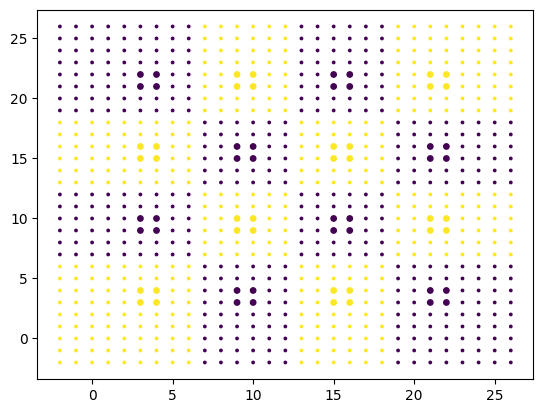

In [38]:
figure = plt.scatter(temp[: ,0], temp[:, 1], s = 3, c = y_hat_grid)
figure = plt.scatter(x[:, 0], x[:, 1], s = 15, c = y_hat_data)

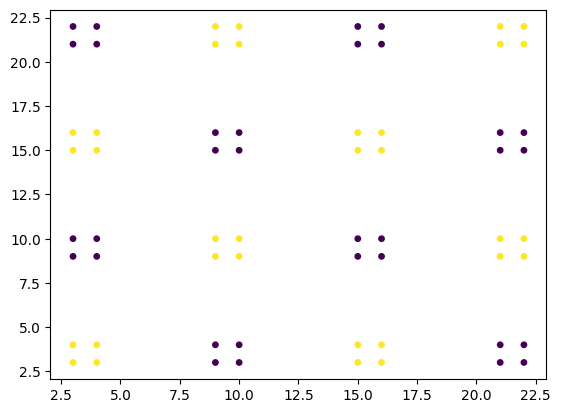

In [39]:
og = figure = plt.scatter(x[:, 0], x[:, 1], s = 15, c = y)

# Flame data

In [21]:
x, y, alpha = kernelized_svm_from_txt(open("Flame.txt"))
print(x)
print(y)
print(alpha)

[[ 1.85 27.8 ]
 [ 1.35 26.65]
 [ 1.4  23.25]
 [ 0.85 23.05]
 [ 0.5  22.35]
 [ 0.65 21.35]
 [ 1.1  22.05]
 [ 1.35 22.65]
 [ 1.95 22.8 ]
 [ 2.4  22.45]
 [ 1.8  22.  ]
 [ 2.5  21.85]
 [ 2.95 21.4 ]
 [ 1.9  21.25]
 [ 1.35 21.45]
 [ 1.35 20.9 ]
 [ 1.25 20.35]
 [ 1.75 20.05]
 [ 2.   20.6 ]
 [ 2.5  21.  ]
 [ 1.7  19.05]
 [ 2.4  20.05]
 [ 3.05 20.45]
 [ 3.7  20.45]
 [ 3.45 19.9 ]
 [ 2.95 19.5 ]
 [ 2.4  19.4 ]
 [ 2.4  18.25]
 [ 2.85 18.75]
 [ 3.25 19.05]
 [ 3.95 19.6 ]
 [ 2.7  17.8 ]
 [ 3.45 18.05]
 [ 3.8  18.55]
 [ 4.   19.1 ]
 [ 4.45 19.9 ]
 [ 4.65 19.15]
 [ 4.85 18.45]
 [ 4.3  18.05]
 [ 3.35 17.3 ]
 [ 3.7  16.3 ]
 [ 4.4  16.95]
 [ 4.25 17.4 ]
 [ 4.8  17.65]
 [ 5.25 18.25]
 [ 5.75 18.55]
 [ 5.3  19.25]
 [ 6.05 19.55]
 [ 6.5  18.9 ]
 [ 6.05 18.2 ]
 [ 5.6  17.8 ]
 [ 5.45 17.15]
 [ 5.05 16.55]
 [ 4.55 16.05]
 [ 4.95 15.45]
 [ 5.85 14.8 ]
 [ 5.6  15.3 ]
 [ 5.65 16.  ]
 [ 5.95 16.8 ]
 [ 6.25 16.4 ]
 [ 6.1  17.45]
 [ 6.6  17.65]
 [ 6.65 18.3 ]
 [ 7.3  18.35]
 [ 7.85 18.3 ]
 [ 7.15 17.8 ]
 [ 7.6  17

/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


In [22]:
temp = make_grid(x)
print(temp[:, 1])

[ 9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45
  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45  9.45
 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45
 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45 10.45
 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45
 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45 11.45
 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45
 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45 12.45
 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45
 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45 13.45
 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45
 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45 14.45
 15.45 15.45 15.45 15.45 15.45 15.45 15.45 15.45 15.45 15.45 15.45 15.45
 15.45 15.45 15.45 15.45 15.45 15.45 15.45 15.45 15

In [23]:
b = get_bias(alpha, x, y)
y_hat_grid = classify(alpha, x, y, temp, b)
y_hat_data = classify(alpha, x, y, x, b)

576
240


In [24]:
print(len(y_hat_grid), len(temp))
print(len(y_hat_data), len(x))

576 576
240 240


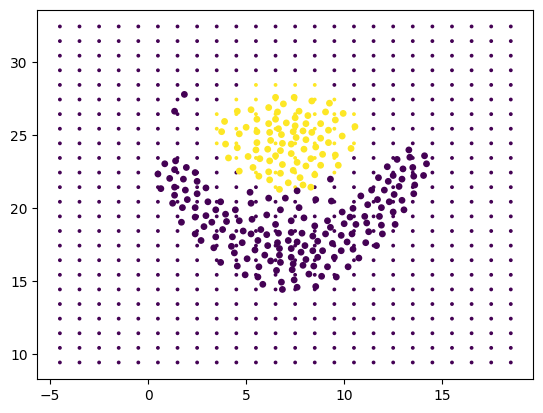

In [25]:
figure = plt.scatter(temp[: ,0], temp[:, 1], s = 3, c = y_hat_grid)
figure = plt.scatter(x[:, 0], x[:, 1], s = 15, c = y_hat_data)

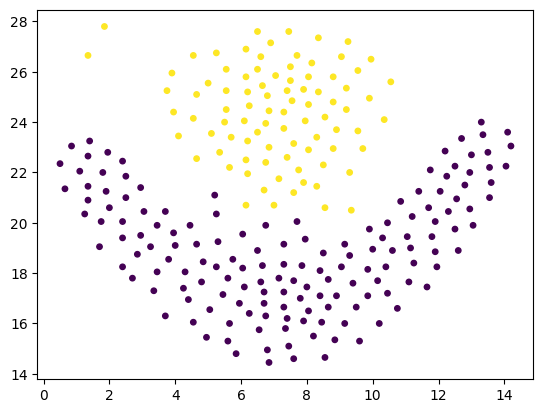

In [26]:
og = figure = plt.scatter(x[:, 0], x[:, 1], s = 15, c = y)

# Jain data

In [27]:
x, y, alpha = kernelized_svm_from_txt(open("Jain.txt"))
print(x)
print(y)
print(alpha)

[[ 0.85 17.45]
 [ 0.75 15.6 ]
 [ 3.3  15.45]
 [ 5.25 14.2 ]
 [ 4.9  15.65]
 [ 5.35 15.85]
 [ 5.1  17.9 ]
 [ 4.6  18.25]
 [ 4.05 18.75]
 [ 3.4  19.7 ]
 [ 2.9  21.15]
 [ 3.1  21.85]
 [ 3.9  21.85]
 [ 4.4  20.05]
 [ 7.2  14.5 ]
 [ 7.65 16.5 ]
 [ 7.1  18.65]
 [ 7.05 19.9 ]
 [ 5.85 20.55]
 [ 5.5  21.8 ]
 [ 6.55 21.8 ]
 [ 6.05 22.3 ]
 [ 5.2  23.4 ]
 [ 4.55 23.9 ]
 [ 5.1  24.4 ]
 [ 8.1  26.35]
 [10.15 27.7 ]
 [ 9.75 25.5 ]
 [ 9.2  21.1 ]
 [11.2  22.8 ]
 [12.6  23.1 ]
 [13.25 23.5 ]
 [11.65 26.85]
 [12.45 27.55]
 [13.3  27.85]
 [13.7  27.75]
 [14.15 26.9 ]
 [14.05 26.55]
 [15.15 24.2 ]
 [15.2  24.75]
 [12.2  20.9 ]
 [12.15 21.45]
 [12.75 22.05]
 [13.15 21.85]
 [13.75 22.  ]
 [13.95 22.7 ]
 [14.4  22.65]
 [14.2  22.15]
 [14.1  21.75]
 [14.05 21.4 ]
 [17.2  24.8 ]
 [17.7  24.85]
 [17.55 25.2 ]
 [17.   26.85]
 [16.55 27.1 ]
 [19.15 25.35]
 [18.8  24.7 ]
 [21.4  25.85]
 [15.8  21.35]
 [16.6  21.15]
 [17.45 20.75]
 [18.   20.95]
 [18.25 20.2 ]
 [18.   22.3 ]
 [18.6  22.25]
 [19.2  21.95]
 [19.45 22

In [28]:
temp = make_grid(x)
print(temp[:, 1])

[-2.05 -2.05 -2.05 ... 31.95 31.95 31.95]


In [29]:
b = get_bias(alpha, x, y)
y_hat_grid = classify(alpha, x, y, temp, b)
y_hat_data = classify(alpha, x, y, x, b)

1785
373


In [30]:
print(len(y_hat_grid), len(temp))
print(len(y_hat_data), len(x))

1785 1785
373 373


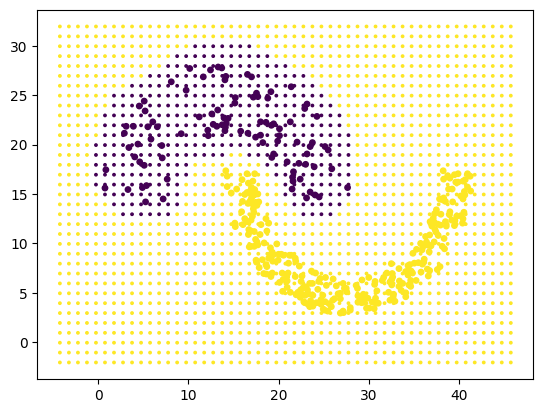

In [31]:
figure = plt.scatter(temp[: ,0], temp[:, 1], s = 3, c = y_hat_grid)
figure = plt.scatter(x[:, 0], x[:, 1], s = 15, c = y_hat_data)

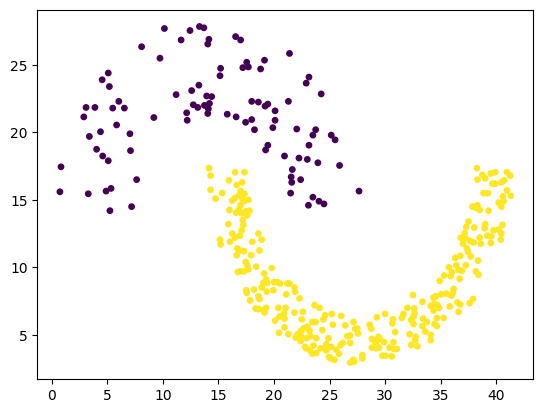

In [32]:
og = figure = plt.scatter(x[:, 0], x[:, 1], s = 15, c = y)